# **Weather forecasting with Deep Learning** 

<pre>
Deep Learning with Python and Lua - Home Assignment 3

Author: <i>Nyikovics Máté</i>
2019.10.26.
</pre>

### To run this notebook

**Locally:**

Please clone or download [this](https://github.com/nyikovicsmate/dlipwpal.khf3.git) repository.
<pre>
The folder structure should look like this:
 ./khf3.ipynb                (this notebook)
 ./download_latest.sh        (this script downloads the latest weather data from NCEI)
 ./data                      (the pre-downloaded weather data)
       /BUDAPEST.dly
       /BUDAPEST_PESTSZENTLORINC.dly
       /etc...     
</pre> 

If you want the latest weather data, please run the *download_latest.sh* script. *Please note, that this will delete the contents of the data/ directory!*

**On Google Colab:**

Please uncomment the lines in the following cell.

In [0]:
# initialize notebook environment in google colab
#!wget --no-verbose -O khf3_env.zip https://github.com/nyikovicsmate/dlipwpal.khf3/raw/master/khf3_env.zip
#!apt install unzip
#!unzip khf3_env.zip

## Getting the data

I got my data through the [National Centers for Environmental Information (NCEI)](https://www.ncdc.noaa.gov/) organization. This US based organization collects and stores environmental data collected from various sources around the globe from as early as the early 1900s. Among the datasources i found 10 land based stations located in Hungary, all of which i am using during this assignment.

The organization has a simple web based interface to search for weather stations/data found under [this link](https://www.ncdc.noaa.gov/cdo-web/datatools/findstation), however for the enthusiast i would highly recomment browsing the organization's [ftp archive](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily) instead.


In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn.preprocessing
import tensorflow as tf
import tensorflow.keras as keras
import copy

Before working with the Global Historical Climatology Network Daily (GHCND) data, we have to familiarize ourselves with it's format.

<PRE>
    <i>(snippet from the organization's readme.txt)</i>
    
    The <b>DAILY GLOBAL HISTORICAL CLIMATOLOGY NETWORK (GHCN-DAILY)</b> dataset is formatted in the following manner:
    
    Each ".dly" file contains data for one station.  The name of the file
    corresponds to a station's identification code.  For example, "USC00026481.dly"
    contains the data for the station with the identification code USC00026481).

    Each record in a file contains one month of daily data.  The variables on each
    line include the following:

    ------------------------------
    Variable   Columns   Type
    ------------------------------
    ID            1-11   Character
    YEAR         12-15   Integer
    MONTH        16-17   Integer
    ELEMENT      18-21   Character
    VALUE1       22-26   Integer
    MFLAG1       27-27   Character
    QFLAG1       28-28   Character
    SFLAG1       29-29   Character
    VALUE2       30-34   Integer
    MFLAG2       35-35   Character
    QFLAG2       36-36   Character
    SFLAG2       37-37   Character
      .           .          .
      .           .          .
      .           .          .
    VALUE31    262-266   Integer
    MFLAG31    267-267   Character
    QFLAG31    268-268   Character
    SFLAG31    269-269   Character
    ------------------------------
    
    These variables have the following definitions:

    ID         is the station identification code.  Please see "ghcnd-stations.txt"
               for a complete list of stations and their metadata.
    YEAR       is the year of the record.

    MONTH      is the month of the record.

    ELEMENT    is the element type.   There are five core elements as well as a number
               of addition elements.  
	   
               The five core elements are:

               PRCP = Precipitation (tenths of mm)
               SNOW = Snowfall (mm)
               SNWD = Snow depth (mm)
               TMAX = Maximum temperature (tenths of degrees C)
               TMIN = Minimum temperature (tenths of degrees C)
               
               ...
		   
    VALUE1     is the value on the first day of the month (missing = -9999).

    MFLAG1     is the measurement flag for the first day of the month.  

    QFLAG1     is the quality flag for the first day of the month. 

    SFLAG1     is the source flag for the first day of the month.

    VALUE2     is the value on the second day of the month

    MFLAG2     is the measurement flag for the second day of the month.

    QFLAG2     is the quality flag for the second day of the month.

    SFLAG2     is the source flag for the second day of the month.

    ... and so on through the 31st day of the month.  Note: <b>If the month has less 
    than 31 days, then the remaining variables are set to missing (e.g., for April, 
    VALUE31 = -9999, MFLAG31 = blank, QFLAG31 = blank, SFLAG31 = blank).</b>

</PRE>

In [0]:
# Global Historical Climatology Network Daily data loader class
class GHCNDLoader():
    data_dir = os.path.join(os.getcwd(), 'data')

    def load_dataframe(self, filename) -> pd.DataFrame:
        # file extension, existence check
        *_, extension = filename.split('.')
        if extension != 'dly':
            raise Exception('Wrong filetype. Need ".dly"')        
        path = os.path.join(GHCNDLoader.data_dir, filename)
        if not os.path.exists(path):
            raise Exception(f'"{path}" missing')    
        # read the file contents as string
        with open(path, 'r') as f:
          self.data_s = f.read()
        # create a dictionary with a wide set of days as indexes
        self.temp = {}
        date_range = pd.date_range(start='1900-01-01', end='2020-01-01')
        for date in date_range:
            self.temp[date] = {'max':None, 'min':None}
        
        self.replace_missing_with_NaN()
        self.extract_temperature_values()
        df = pd.DataFrame(data=self.temp.values(), index=self.temp.keys())        
        return df
    
    def replace_missing_with_NaN(self) -> None:
        '''Replaces every missing value in the dataset with NaN to ease further processing.'''
        self.data_s = self.data_s.replace('-9999', '  NaN E')

    def extract_temperature_values(self) -> None:
        '''Extracts the t_min and t_max values from the dataset and the corresponding dates \
        and parses them into the previously created self.temp dictionary.'''
        # split the data_s string first by lines, then by whitespaces
        # to effectively get a (_, 63) shaped matrix
        # (63 = 1 identifier column + 31 value colums (1/day of month) + 31 flag colums (read the docs snippet above for further explanation))
        data = [v.split() for v in self.data_s.splitlines()]
        # process each row, extract the temperature values
        for row in data:
            identification_code = row[0]
            year = int(identification_code[11:15])
            month = int(identification_code[15:17])
            element = identification_code[17:21]
            # only care about the temperature values
            if element != 'TMAX' and element != 'TMIN':
                continue
            # get every 2nd column (these contain the raw values)
            values = [v for v in row[1::2]]
            # each row should contain 31 days of data (shorter months get padded by NaN values)
            if len(values) != 31:
                raise Exception(f'Something went wrong.\n{values}')
            for i in range(len(values)):
                try:
                    # create the datestamp for the value
                    date = pd.Timestamp(f'{year}-{month}-{i+1}')
                    # append the values to the self.temp dictionary using the timestamp as key while also
                    # dividing them by 10, because temperatures are stored as tenths of degree C
                    if element == 'TMAX':
                        self.temp[date]['max'] = float(values[i]) / 10.0 if values[i] != 'NaN' else None
                    elif element == 'TMIN':
                        self.temp[date]['min'] = float(values[i]) / 10.0 if values[i] != 'NaN' else None
                except ValueError:
                    # invalid date, this can happen if we try to parse a padded date e.g. 1999.02.31.
                    # just ignore it
                    pass        

In [4]:
# import the data into python objects
ghcnd_loader = GHCNDLoader()
df = {}
with os.scandir('data/') as entries:
    for entry in entries:
        *name, ext = entry.name.split('.')
        if ext == 'dly':
            name = ''.join(name)
            df[name] = ghcnd_loader.load_dataframe(entry.name)
            print(f'Loaded {entry.name} under index [{name}]')

Loaded PECS_POGANY.dly under index [PECS_POGANY]
Loaded NAGYKANIZSA.dly under index [NAGYKANIZSA]
Loaded SZEGED.dly under index [SZEGED]
Loaded MISKOLC.dly under index [MISKOLC]
Loaded DEBRECEN_AIRPORT.dly under index [DEBRECEN_AIRPORT]
Loaded BUDAPEST.dly under index [BUDAPEST]
Loaded SZOMBATHELY.dly under index [SZOMBATHELY]
Loaded SZEGED_AUT.dly under index [SZEGED_AUT]
Loaded DEBRECEN.dly under index [DEBRECEN]
Loaded BUDAPEST_PESTSZENTLORINC.dly under index [BUDAPEST_PESTSZENTLORINC]


In [5]:
# sample data from the BUDAPEST dataframe
df['BUDAPEST']['1990-01-01':'1990-01-10'].head(10)

,max,min
1990-01-01,0.6,-0.8
1990-01-02,0.5,-0.8
1990-01-03,1.1,-1.0
1990-01-04,0.6,-4.7
1990-01-05,0.6,-4.6
1990-01-06,-2.0,-5.8
1990-01-07,-4.7,-8.4
1990-01-08,-7.4,-8.6
1990-01-09,-4.4,-9.7
1990-01-10,-2.2,-5.8


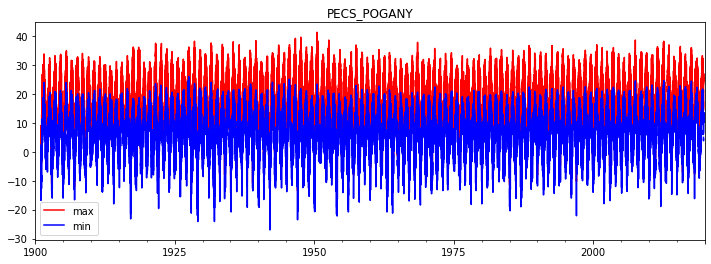

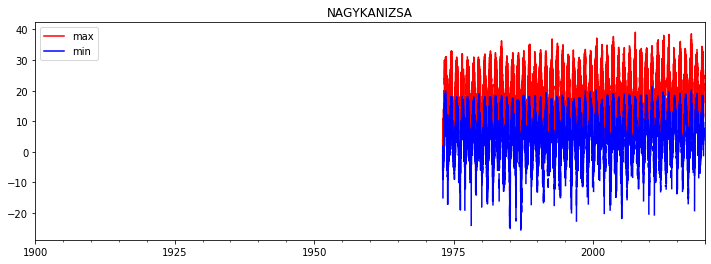

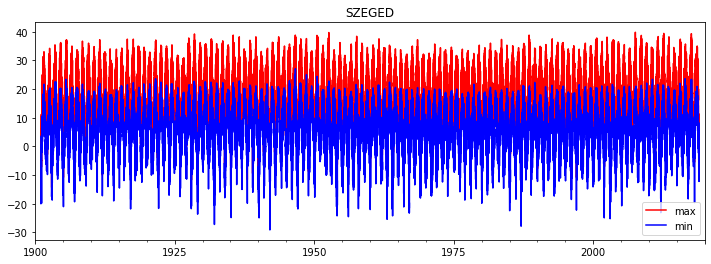

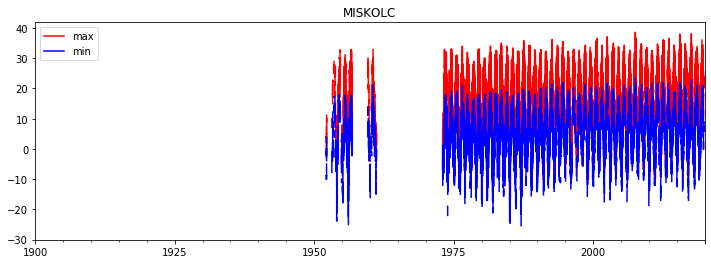

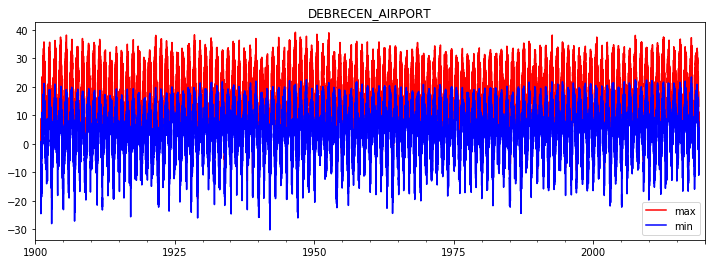

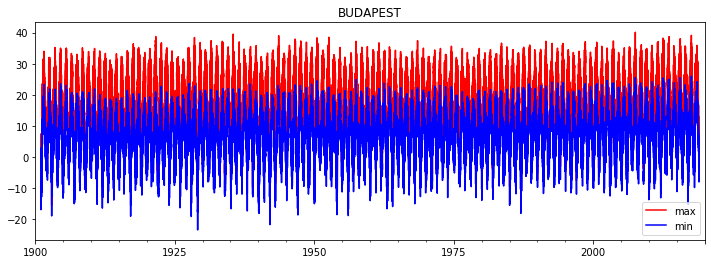

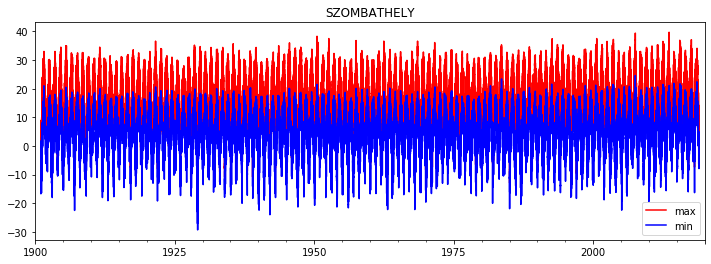

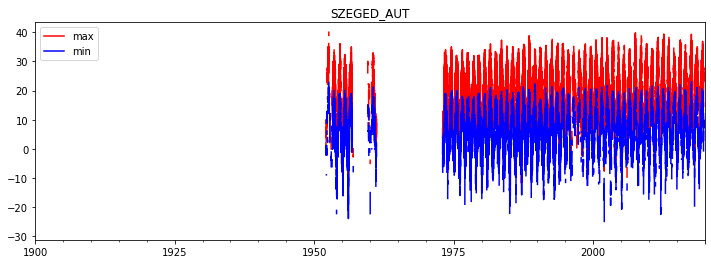

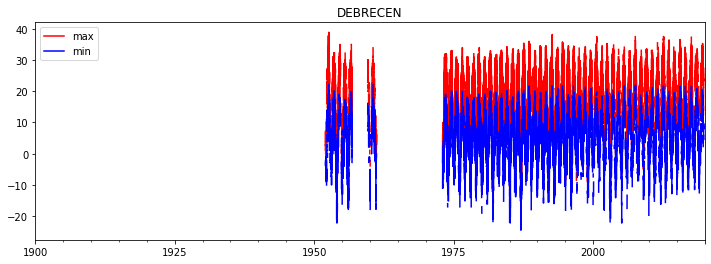

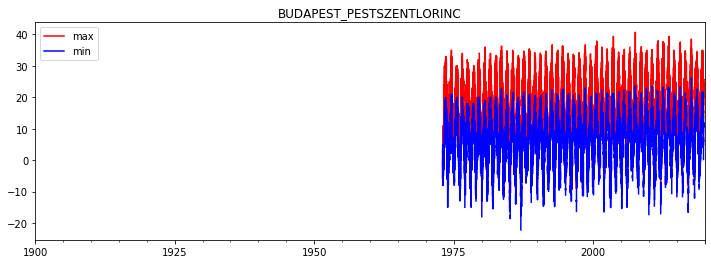

In [6]:
# plot the datasets
for key, value in df.items():
    value.plot(figsize=(12,4), y=['max','min'], color=['red','blue'], title=key)

In [7]:
# figuring out a the date range
for key, value in df.items():
    # we dorp the NaN records from each dataset temporarily, and after whats left, we check for min and max daterange
    desc = value.dropna(how='any').index.to_series().describe()
    first = desc['first']
    last = desc['last']
    print(f'{key} date range: {first} - {last}')

PECS_POGANY date range: 1901-01-01 00:00:00 - 2019-10-23 00:00:00
NAGYKANIZSA date range: 1973-01-07 00:00:00 - 2019-10-23 00:00:00
SZEGED date range: 1901-01-01 00:00:00 - 2018-12-31 00:00:00
MISKOLC date range: 1952-01-01 00:00:00 - 2019-10-23 00:00:00
DEBRECEN_AIRPORT date range: 1901-01-01 00:00:00 - 2018-12-31 00:00:00
BUDAPEST date range: 1901-01-01 00:00:00 - 2018-12-31 00:00:00
SZOMBATHELY date range: 1901-01-01 00:00:00 - 2018-12-31 00:00:00
SZEGED_AUT date range: 1952-02-04 00:00:00 - 2019-10-23 00:00:00
DEBRECEN date range: 1952-01-04 00:00:00 - 2019-10-23 00:00:00
BUDAPEST_PESTSZENTLORINC date range: 1973-01-05 00:00:00 - 2019-10-23 00:00:00


We can see, that the 5 datasets have data between 1901 and 2018, while the other 5 datasets have data form 1950/70s to the current day. Given that all the data are from Hungary, i decided to pair them up, and combine them.
The pairing:
0. BUDAPEST - BUDAPEST_PESTSZENTLORINC
1. DEBRECEN_AIRPORT - DEBRECEN
2. SZEGED - SZEGED_AUT
3. PECS_POGANY - NAGYKANIZSA
4. SZOMBATHELY - MISKOLC

In [0]:
def update(df_left, df_right):
    '''Updates the left dataframe's NaN values with the right's values, leaves everything else intact.'''
    # make a copy the of dataframe, because the update function changes the object directly
    df = copy.deepcopy(df_left)
    # fill in the NaN values
    df.update(other=df_right, overwrite=False)
    # crop it to range
    desc = df.dropna(how='any').index.to_series().describe()
    first = pd.Timestamp(desc['first'])
    last = pd.Timestamp(desc['last'])
    return df[first:last]

df_paired = {
    0 : update(df['BUDAPEST'], df['BUDAPEST_PESTSZENTLORINC']),
    1 : update(df['DEBRECEN_AIRPORT'], df['DEBRECEN']),
    2 : update(df['SZEGED'], df['SZEGED_AUT']),
    3 : update(df['PECS_POGANY'], df['NAGYKANIZSA']),
    4 : update(df['SZOMBATHELY'], df['MISKOLC'])
}

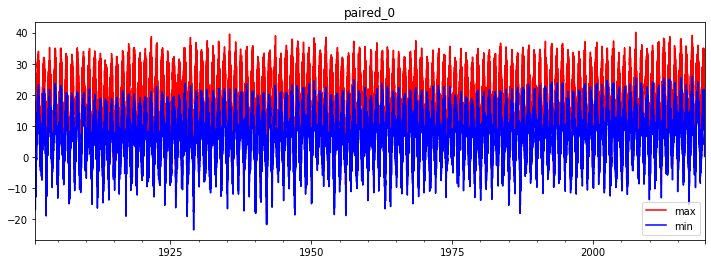

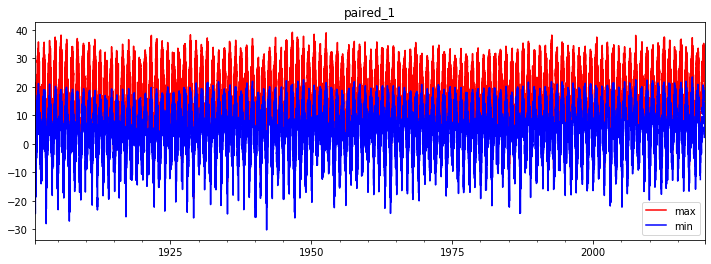

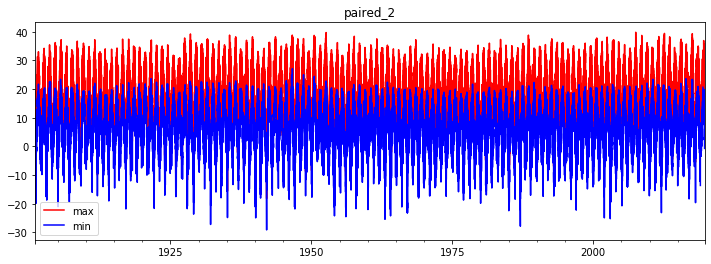

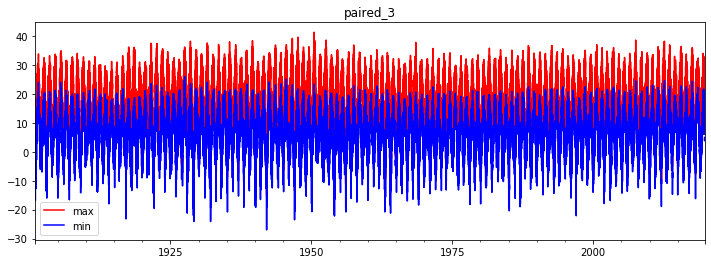

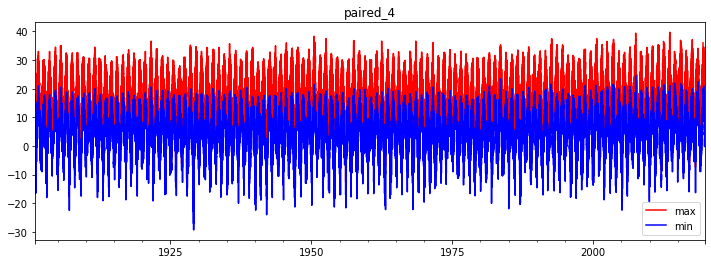

In [9]:
# plot the paired datasets
for key, value in df_paired.items():
    value.plot(figsize=(12,4), y=['max','min'], color=['red','blue'], title=f'paired_{key}')

In [10]:
for value in df_paired.values():
    value.info()
    print()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43395 entries, 1901-01-01 to 2019-10-23
Data columns (total 2 columns):
max    43368 non-null float64
min    43326 non-null float64
dtypes: float64(2)
memory usage: 1017.1 KB

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43395 entries, 1901-01-01 to 2019-10-23
Data columns (total 2 columns):
max    43273 non-null float64
min    43258 non-null float64
dtypes: float64(2)
memory usage: 1017.1 KB

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43395 entries, 1901-01-01 to 2019-10-23
Data columns (total 2 columns):
max    43325 non-null float64
min    43300 non-null float64
dtypes: float64(2)
memory usage: 1017.1 KB

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43395 entries, 1901-01-01 to 2019-10-23
Data columns (total 2 columns):
max    43367 non-null float64
min    43348 non-null float64
dtypes: float64(2)
memory usage: 1017.1 KB

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43395 entries, 1901-01-01 to 20

Looks a lot better. However one can notice, that there are more indexes than values, this indicates that the values have gaps between them. Next i'll solve this problem by interpolating over the gaps. 

In [11]:
# check for NaN data
for key, value in df_paired.items():
    print(f'df[{key}] null value count:\n{value.isna().sum()}')

df[0] null value count:
max    27
min    69
dtype: int64
df[1] null value count:
max    122
min    137
dtype: int64
df[2] null value count:
max    70
min    95
dtype: int64
df[3] null value count:
max    28
min    47
dtype: int64
df[4] null value count:
max    33
min    69
dtype: int64


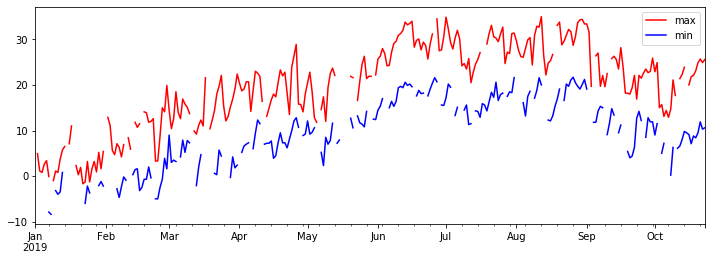

In [12]:
# plot a zoomed in version of one of the paired dataframes, this clearly shows the gaps 
df_paired[0]['2019':].plot(figsize=(12,4), y=['max','min'], color=['red','blue'])

To fix the missing data problem, i interpolate the data between the closest datapoints, thus creating new values. The plot below illustrates the process. 

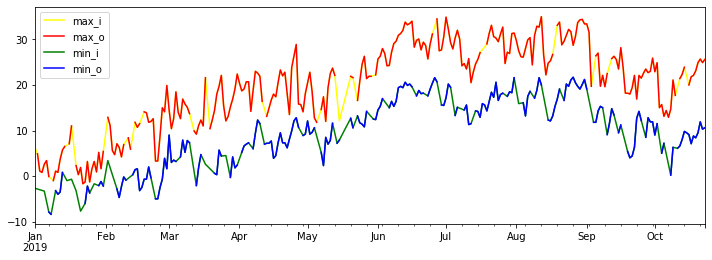

In [13]:
# illustrating the effects of interpolation
df_interpolated = df_paired[0].interpolate(method='time').join(df_paired[0], lsuffix='_i', rsuffix='_o')
df_interpolated['2019':].plot(figsize=(12,4), y=['max_i', 'max_o', 'min_i', 'min_o'], color=['yellow','red','green','blue'])

In [14]:
# make the interpolation permanent
for key in df_paired:
    df_paired[key] = df_paired[key].interpolate(method='time')

# checking for nulls again
for key, value in df_paired.items():
    print(f'df[{key}] null value count:\n{value.isna().sum()}')

df[0] null value count:
max    0
min    0
dtype: int64
df[1] null value count:
max    0
min    0
dtype: int64
df[2] null value count:
max    0
min    0
dtype: int64
df[3] null value count:
max    0
min    0
dtype: int64
df[4] null value count:
max    0
min    0
dtype: int64


Now we have exactly the same number of min, max values as indexes (for each date we have a max and min value).

The next step is to join the paired dataframes into one big frame.

To help the network, i also experimented with adding the day of the year and the season (0 - winter (DJF), 1 - spring (MAM), 2 - summer (JJA) 3 - autumn (SON)) as separate columns to the dataframe, this yielded notable improvements.

In [15]:
# join the dataframes
df_all = df_paired[0].join(other=df_paired[1], how='left', rsuffix='_1')
df_all = df_all.join(other=df_paired[2], how='left', rsuffix='_2')
df_all = df_all.join(other=df_paired[3], how='left', rsuffix='_3')
df_all = df_all.join(other=df_paired[4], how='left', rsuffix='_4')

# add the "helper" columns 
df_all['dayofyear'] = df_all.index.dayofyear
df_all['season'] = [0 if date.month in [12,1,2] else 
                    1 if date.month in [3,4,5] else 
                    2 if date.month in [6,7,8] else 
                    3 for date in df_all.index]

df_all.tail()

,max,min,max_1,min_1,max_2,min_2,max_3,min_3,max_4,min_4,dayofyear,season
2019-10-19,23.1,8.4,23.30,8.7,24.5,8.6,22.0,10.5,21.6,7.3,292,3
2019-10-20,24.9,9.5,24.70,8.4,25.6,7.3,23.8,10.1,22.9,7.5,293,3
2019-10-21,25.7,11.9,24.95,8.5,27.1,7.6,25.4,13.6,24.0,7.5,294,3
2019-10-22,24.9,10.3,25.20,7.9,27.8,9.9,27.0,12.8,23.1,9.0,295,3
2019-10-23,25.6,10.6,27.30,8.7,27.5,7.3,24.5,12.5,23.8,8.6,296,3


### Training, validation data

Now that i've got my big dataframe, i separated it into training and validation datasets at the ratio of 80% to 20%. Furthermore, because i ultimately want to predict the future (not the present), i shifted the two frames by 6 weeks (35 days), as illustrated by the image below.

![](https://github.com/nyikovicsmate/dlipwpal.khf3/raw/master/shift.png)

In [16]:
# i try to predict 6 weeks into the future (1.5 months)
days_to_predict = 6 * 7
# shift the training and validation data
x = df_all.values[:-days_to_predict]
y = df_all.values[days_to_predict:]
# keep only the BUDAPEST dataframe's min, max values as output
y = np.delete(arr=y, obj=[2,3,4,5,6,7,8,9,10,11], axis=1)

# the data in the frame is ranging form approx. -40 +40 values, so
# i scale it down for the network
x_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
y_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))

x_scaled = x_scaler.fit_transform(x)
y_scaled = y_scaler.fit_transform(y)

print(f'x:\n{x[1]}\n')
print(f'x scaled:\n{x_scaled[1]}\n')
print(f'y:\n{y[1]}\n')
print(f'y scaled:\n{y_scaled[1]}\n')

train_validation_ratio = 0.8
split_idx = int(len(x_scaled)*train_validation_ratio)
x_train = x_scaled[:split_idx]
x_test = x_scaled[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]

print(f'Train data input shape: {x_train.shape}')
print(f'Train data output shape: {y_train.shape}')
print(f'Test data input shape: {x_test.shape}')
print(f'Test data output shape: {y_test.shape}')

x:
[ -6.6 -11.3 -10.  -15.2  -8.5 -13.2  -7.5 -12.9  -8.8 -12.2   2.    0. ]

x scaled:
[0.1975945  0.24493927 0.15753425 0.27932961 0.16724138 0.28291815
 0.16295026 0.26603774 0.13237925 0.31725417 0.00273973 0.        ]

y:
[-2.  -8.8]

y scaled:
[0.2766323  0.29554656]

Train data input shape: (34682, 12)
Train data output shape: (34682, 2)
Test data input shape: (8671, 12)
Test data output shape: (8671, 2)


## Recurrent Neural Network

For the network i am using two Gated Recurrent Units as the first two layers. The purpose of these is to memorize/learn the long time patters found in the data. The input of these layers is the big dataframe consisting of 12 columns (the min-max temperature values for 5 cities + the day of the year and season helper columns).
For the last/output layer i am using a Dense/Fully connected layer to map the output of the GRUs to 2 temperature min-max values. I am aware that by using sigmoid activation in the dense layer i am confining the network, meaning i can not get an output greater/less than the largest/smallest input data, but given that i want to predict late autumn temperatures a greater peak or low is a highly unlikely occurence (in the current climate at least).      

![](https://github.com/nyikovicsmate/dlipwpal.khf3/raw/master/network.png)

In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, 12)
        x_batch = np.zeros(shape=x_shape, dtype=np.float32)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, 2)
        y_batch = np.zeros(shape=y_shape, dtype=np.float32)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(len(x_train) - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train[idx:idx+sequence_length]
            y_batch[i] = y_train[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)
        
generator = batch_generator(batch_size=256,
                            sequence_length=4*days_to_predict)

In [18]:
# define the neural network
model = keras.models.Sequential()
model.add(keras.layers.GRU(units=256,
              return_sequences=True,
              input_shape=(None, 12,)))
model.add(keras.layers.GRU(units=256,
              return_sequences=True))
model.add(keras.layers.Dense(2, activation='sigmoid'))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 256)         206592    
_________________________________________________________________
gru_1 (GRU)                  (None, None, 256)         393984    
_________________________________________________________________
dense (Dense)                (None, None, 2)           514       
Total params: 601,090
Trainable params: 601,090
Non-trainable params: 0
_________________________________________________________________


In [0]:
# saving the best model
path_checkpoint = 'forecast_checkpoint.keras'
callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [0]:
# early stopping to avoid overfitting
callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint]

In [22]:
model.reset_states()
model.fit_generator(generator=generator,
                    epochs=100,
                    steps_per_epoch=10,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=(np.expand_dims(x_test, axis=0), np.expand_dims(y_test, axis=0)))

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.01602, saving model to forecast_checkpoint.keras
10/10 - 15s - loss: 0.0248 - val_loss: 0.0160
Epoch 2/100
Epoch 1/100

Epoch 00002: val_loss improved from 0.01602 to 0.01259, saving model to forecast_checkpoint.keras
10/10 - 12s - loss: 0.0141 - val_loss: 0.0126
Epoch 3/100
Epoch 1/100

Epoch 00003: val_loss improved from 0.01259 to 0.01119, saving model to forecast_checkpoint.keras
10/10 - 12s - loss: 0.0113 - val_loss: 0.0112
Epoch 4/100
Epoch 1/100

Epoch 00004: val_loss improved from 0.01119 to 0.01009, saving model to forecast_checkpoint.keras
10/10 - 12s - loss: 0.0103 - val_loss: 0.0101
Epoch 5/100
Epoch 1/100

Epoch 00005: val_loss improved from 0.01009 to 0.00936, saving model to forecast_checkpoint.keras
10/10 - 12s - loss: 0.0094 - val_loss: 0.0094
Epoch 6/100
Epoch 1/100

Epoch 00006: val_loss improved from 0.00

In [0]:
# training is over, load the best model
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [0]:
# predit future temperatures using the last 6 weeks as input
y_pred = model.predict(np.expand_dims(x_scaler.transform(df_all.values[-days_to_predict:]), axis=0))

In [25]:
# put predition values into a dataframe
last_date = df_all.index.to_series().describe()['last']
df_pred = pd.DataFrame(data=y_scaler.inverse_transform(y_pred[0]), columns=['max', 'min'], index = pd.date_range(start=last_date, periods=days_to_predict))
df_pred.head()

,max,min
2019-10-23,16.579531,8.200600
2019-10-24,17.698450,9.696358
2019-10-25,17.704763,9.605933
2019-10-26,16.788916,8.788325
2019-10-27,15.864249,7.945055


In [0]:
# calculate the mean along the columns & add to the dataframe
df_pred['mean'] = list(df_pred.mean(axis=1))

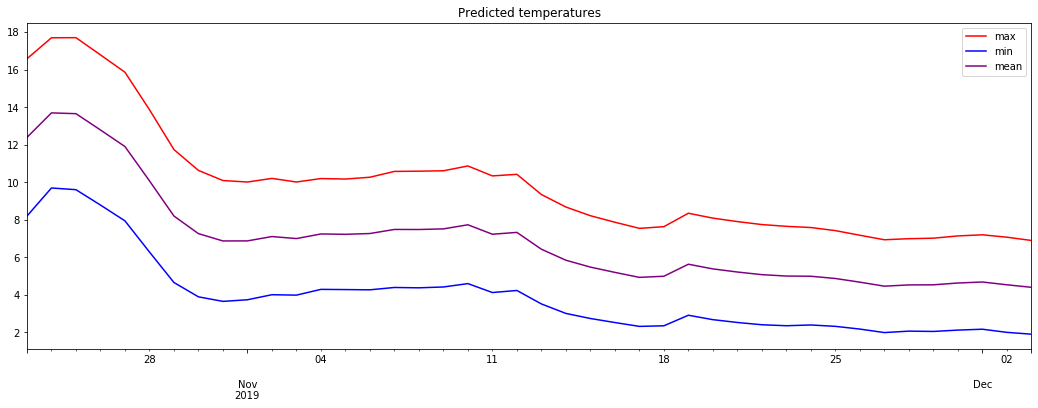

In [27]:
df_pred.plot(figsize=(18,6), y=['max','min','mean'], color=['red','blue','purple'], title='Predicted temperatures')

In [28]:
# print the means for the given dates
print(f'okt. 30. mean: {df_pred["mean"]["2019-10-30"]:0.2f} degree C ')
print(f'nov. 5. mean: {df_pred["mean"]["2019-11-05"]:0.2f} degree C ')
print(f'nov. 26. mean: {df_pred["mean"]["2019-11-26"]:0.2f} degree C ')

okt. 30. mean: 7.26 degree C 
nov. 5. mean: 7.23 degree C 
nov. 26. mean: 4.68 degree C 
